<a href="https://colab.research.google.com/github/Himanshu-Dharma/master-thesis-feature-extraction-and-sentiment-analysis-using-deep-learning/blob/main/Thesis_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Description


1. **reviewerID** - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. **asin** - ID of the product, e.g. 0000013714
3. **reviewerName** - name of the reviewer
4. **vote** - helpful votes of the review
5. **style** - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
6. **reviewText** - text of the review
7. **overall** - rating of the product
8. **summary** - summary of the review
9. **unixReviewTime** - time of the review (unix time)
10. **reviewTime** - time of the review (raw)
11. **image** - images that users post after they have received the product

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For Word Cloud
from wordcloud import WordCloud
from os import path
from PIL import Image

# For Data Preprocessing
import re
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Splitting dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Loading the data

In [ ]:
df_primary = pd.read_json("/content/drive/MyDrive/ThesisData/thesis_data_primary.json")

# Exploratory Data Analysis

In [ ]:
df_primary.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,90,False,"08 9, 2004",AXHY24HWOF184,0470536454,{'Format:': ' Paperback'},Bendy,Crocheting for Dummies by Karen Manthey & Susa...,Terrific Book for Learning the Art of Crochet,1092009600,NaN
1,4,2,True,"04 6, 2017",A29OWR79AM796H,0470536454,{'Format:': ' Hardcover'},Amazon Customer,Very helpful...,Four Stars,1491436800,NaN


## Checking for Null values

In [ ]:
#total number of rows and coluns in our dataset
df_primary.shape

(1512530, 12)

In [ ]:
#Total number of null values per column
df_primary.isnull().sum()

overall                 0
vote              1268582
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              839992
reviewerName          150
reviewText            855
summary               380
unixReviewTime          0
image             1482365
dtype: int64

##Rating(star) Distribution

In [ ]:
df_overall = df_primary['overall'].value_counts()
df_overall = df_overall.reset_index()
df_overall.columns = ['Rating', 'Count']
df_overall

,Rating,Count
0,5,984097
1,4,237295
2,1,118102
3,3,106249
4,2,66787


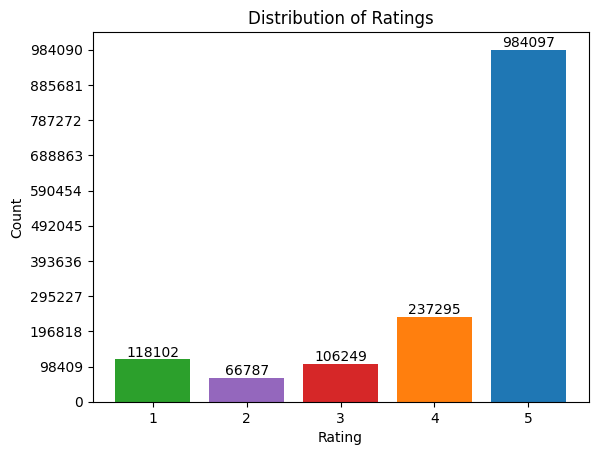

In [ ]:
plt.bar(df_overall['Rating'], df_overall['Count'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Adding labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')

# Adding numbers on top of each bar
for i, value in enumerate(df_overall['Count']):
    plt.annotate(str(value), (df_overall['Rating'][i], value), ha='center', va='bottom')

# Setting the y-axis tick interval as the values in the data are > 100000
plt.yticks(range(0, max(df_overall['Count']), int(max(df_overall['Count'])/10)))

# Displaying the graph
plt.show()

## Word cloud

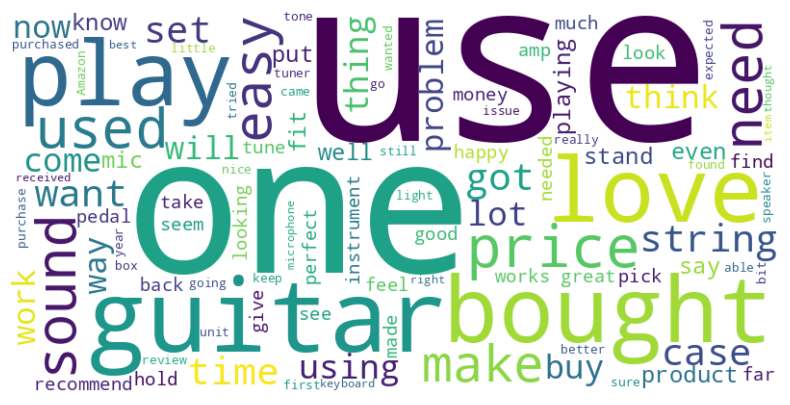

In [ ]:
#Word cloud
from wordcloud import WordCloud

#text column
df_primary['reviewText'] = df_primary['reviewText'].astype(str)
text_data = ' '.join(df_primary['reviewText'])

# Creating a WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text_data)

# Displaying the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Unique product reviews



**112222** Unique products are reviewed, and most reviewed product contains **5082** reviews.

In [ ]:
products = df_primary.asin
products.value_counts()

B000VSM4MS    5082
B004XNK7AI    4704
B00IFOTSJW    4110
B000XI6O2W    3924
B00XQFONF4    3901
              ... 
B00GFRHD5W       1
B00GFUU1IA       1
B00GFU9PC8       1
B0029BS3GG       1
B01HJEFFTK       1
Name: asin, Length: 112222, dtype: int64

In [ ]:
df_primary['reviewTime'] = pd.to_datetime(df_primary['reviewTime'], format='%m %d, %Y')

## Unique users

**903330** Unique Users posted reviews, and user with most reviews posted **506** reviews.

In [ ]:
user = df_primary.reviewerID
user.value_counts()

A2NYK9KWFMJV4Y    506
A3YVD62FSVIUJ     275
A396ELNTQDFYPO    226
ADH0O8UVJOT10     193
ALHC64J88LVWO     151
                 ... 
A3KIXS1TR8C178      1
AV4FOTICGNCKH       1
AXXPHF223THY6       1
A2U49PHFCOZGAC      1
A3HAXIG8WVVDB7      1
Name: reviewerID, Length: 903330, dtype: int64

## Labeling positive and negative reviews

# Preprocessing the Data - part 1

## Libraries

In [ ]:
from bs4 import BeautifulSoup
import spacy
import gensim.downloader as api

## Data cleaning

### Missing values

In [ ]:
import pandas as pd

# Assuming df is your DataFrame and 'column_name' is the name of the column to check
threshold = 0.55  # Set the threshold as 55%

for cname in df_primary:
  missing_percentage = df_primary[cname].isnull().mean()  # Calculate the percentage of missing values
  if missing_percentage >= threshold:
    print("The column has {}% or more missing values.".format(missing_percentage * 100))
  else:
    print("The column has less than {}% missing values.".format(threshold * 100))

NameError: ignored

In [ ]:
df_new = df_primary.drop(columns=['vote','style','image'])

NameError: ignored

In [ ]:
# Assuming df is your DataFrame and 'column_name' is the name of the column with missing values
column_name1 = 'reviewText'

# Remove rows with missing values in the specified column
df_new = df_new.dropna(subset=[column_name1])

# Display the cleaned DataFrame
print(df_new)

In [ ]:
df_new.shape

In [ ]:
df_primary.shape

In [ ]:
df_clean = df_new.drop(columns=['reviewerName','summary'])

In [ ]:
df_clean.head()

### Duplicates

In [ ]:
total_duplicates = df_clean.duplicated().sum()

# Display the number of total duplicate rows
print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 37619


In [ ]:
duplicate_rows1 = df_clean[df_clean.duplicated(keep=False)]


In [ ]:
duplicate_rows1

,overall,verified,reviewTime,reviewerID,asin,reviewText,unixReviewTime
3919,5,True,2015-01-08,AH91ZJ8W8NCLR,B00005ML71,A+,1420675200
3920,5,True,2015-01-08,AH91ZJ8W8NCLR,B00005ML71,A+,1420675200
4888,5,True,2014-04-30,A10NPIQCB07BXZ,B000068NUQ,The metal connectors have a quality look. They...,1398816000
4889,5,True,2014-04-30,A10NPIQCB07BXZ,B000068NUQ,The metal connectors have a quality look. They...,1398816000
5026,5,True,2015-03-18,A1Y90O3KRCENSW,B000068NTU,"Great product, performed as advertised.",1426636800
...,...,...,...,...,...,...,...
1491971,5,True,2018-07-26,A3IJSAWNZA89IF,B01C5S15H6,Great quality and looks stunning.,1532563200
1491972,5,True,2018-07-26,A3IJSAWNZA89IF,B01C5S15H6,Great quality and looks stunning.,1532563200
1491973,5,True,2018-07-26,A3IJSAWNZA89IF,B01C5S15H6,Great quality and looks stunning.,1532563200
1504749,1,True,2017-03-17,A1QOF7FTFHVU22,B01FDHB9AY,does not fit the epiphone,1489708800


In [ ]:
# The keep='first' parameter specifies to keep the first occurrence of each duplicated row and remove the subsequent duplicates.
df_clean_no_dups = df_clean.drop_duplicates(keep='first')

In [ ]:
df_clean_no_dups['overall'].value_counts()

5    960812
4    230948
1    114729
3    103417
2     65005
Name: overall, dtype: int64

In [ ]:
df_clean_no_dups

,overall,verified,reviewTime,reviewerID,asin,reviewText,unixReviewTime
0,5,False,2004-08-09,AXHY24HWOF184,0470536454,Crocheting for Dummies by Karen Manthey & Susa...,1092009600
1,4,True,2017-04-06,A29OWR79AM796H,0470536454,Very helpful...,1491436800
2,5,True,2017-03-14,AUPWU27A7X5F6,0470536454,EASY TO UNDERSTAND AND A PROMPT SERVICE TOO,1489449600
3,4,True,2017-02-14,A1N69A47D4JO6K,0470536454,My girlfriend use quite often,1487030400
4,5,True,2017-01-29,AHTIQUMVCGBFJ,0470536454,Arrived as described. Very happy.,1485648000
...,...,...,...,...,...,...,...
1512525,5,True,2018-06-11,A311NUWMD55WPO,B01HJETSF2,Hard to believe anyone will play their prized ...,1528675200
1512526,4,True,2018-06-07,AXJFL8T55OXJG,B01HJETSF2,"Straplocks installed nicely, good fitment on m...",1528329600
1512527,5,True,2018-06-03,A1RHBI07JTQBER,B01HJETSF2,Great Product,1527984000
1512528,5,True,2018-05-29,A1V0G9QMGY1RGK,B01HJETSF2,I honestly expected these to be cheap pieces o...,1527552000


### Removing HTML Tags

In [ ]:
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

### Removing Punctuation

In [ ]:
import string

In [ ]:
def remove_punc(text):
  """ Remove puncuation """
  text = re.sub(r'[^\w\s]','',text)
  return text

### Removing White spaces

In [ ]:
def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

### All lower case

In [ ]:
def lowercase(text):
    """lowercase"""
    text = text.lower()
    return text

### Converting accented characters

In [ ]:
!pip install unidecode
import unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 6.4 MB/s eta 0:00:00


In [ ]:
def remove_accented_chars(text):
    """remove accented characters"""
    text = unidecode.unidecode(text)
    return text

### Stop word removal

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the stopwords corpus if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

def stop_word_removal(text):
  # Set the stop words for the specific language
  stop_words = set(stopwords.words('english'))

  # Tokenize the sentence
  tokens = word_tokenize(text)

  # Remove stop words from the tokens
  filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

  # Join the filtered tokens back into a sentence
  filtered_sentence = ' '.join(filtered_tokens)

  return filtered_sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Applying cleaning functions


*   To remove Html tags
*   White spaces
*   punctuations
*   Convert to lower case
*   Converting accented characters





In [ ]:
def clean(text):
  #html removal:
  text = strip_html_tags(text)
  #removing extra Whitespace:
  text= remove_whitespace(text)
  #all lowercase:
  text = lowercase(text)
  #Converting Accented Charachters:
  text = remove_accented_chars(text)
  #Stop word removal
  text = stop_word_removal(text)
  #Removing punctuation:
  text= remove_punc(text)
  return text
  #stop word removal

In [ ]:
## Use df_clean_no_dups dataframe

df_pre = df_clean_no_dups[["overall","reviewText"]]
df_pre['reviewText'] = df_pre['reviewText'].apply(lambda x : clean(x))
df_pre.tail(3)

In [ ]:
df_pre.to_json('finaldf1.json')

In [ ]:
df_pre2 = pd.read_json("/content/finaldf1.json")

In [ ]:
df_pre2['reviewText'] = df_pre2['reviewText'].astype(str)

### Labelling positive and Negative tweets

In [ ]:
df_pre2["target"] = np.where(df_pre2["overall"] > 3, 1, 0)
df_pre2.head(2)

,overall,reviewText,target
0,5,crocheting dummies karen manthey susan britta...,1
1,4,helpful,1


In [ ]:
from wordcloud import WordCloud
# Create new column "Target" that stored 0's or 1's. 0 being Negative, 1 being Positive
pos = df_pre2[df_pre2['target']==1]['reviewText']
neg = df_pre2[df_pre2['target']==0]['reviewText']
pos.tail(3)

1512527                                        great product
1512528    honestly expected cheap pieces crap  pleasantl...
1512529               straplocks work  look fit well  thank 
Name: reviewText, dtype: object

In [ ]:
positive_samples = final_df[final_df['target'] == 1]
negative_samples = final_df[final_df['target'] == 0]

# Determine the desired ratio of negatives to positives
ratio = len(negative_samples) / len(positive_samples)

In [ ]:
df_pre2.to_json('finaldf_withtarget.json')

### loading the downloaded file

In [4]:
final_df = pd.read_json("/content/drive/MyDrive/ThesisData/finaldf_withtarget.json")

In [5]:
final_df.head()

,overall,reviewText,target
0,5,crocheting dummies karen manthey susan britta...,1
1,4,helpful,1
2,5,easy understand prompt service,1
3,4,girlfriend use quite often,1
4,5,arrived described happy,1


In [ ]:
pos = final_df[final_df['target']==1]['reviewText']
neg = final_df[final_df['target']==0]['reviewText']

#### Positive word cloud

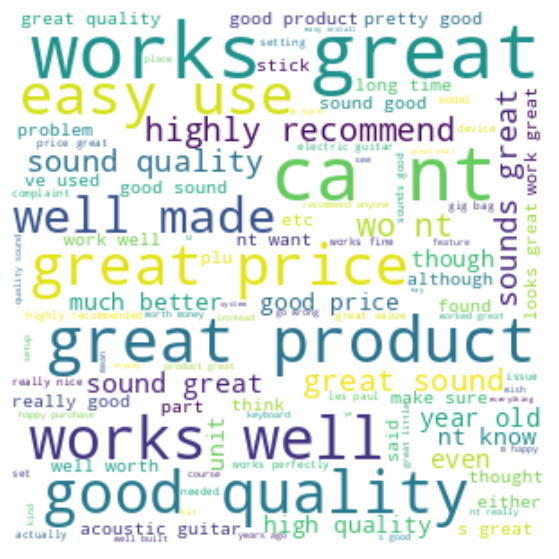

In [ ]:
text_pos = " ".join(i for i in pos)
# Create a word cloud image
wc_pos = WordCloud(width=300, height=300, max_words=100, background_color='white')
wc_pos.generate(text_pos)
plt.figure(figsize=(14,7))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Negative word cloud

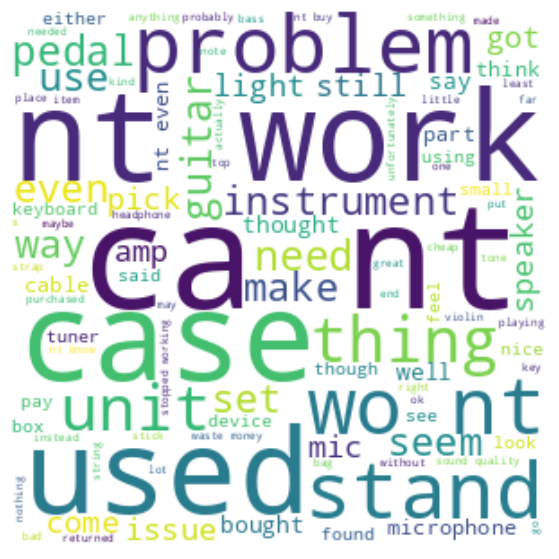

In [ ]:
text_neg = " ".join(i for i in neg)
# Create a word cloud image
wc_neg = WordCloud(width=300, height=300, max_words=100, background_color='white')
wc_neg.generate(text_neg)
plt.figure(figsize=(14,7))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data undersampling

In [6]:
from imblearn.under_sampling import RandomUnderSampler

u1 = final_df['reviewText']
u2 = final_df['target']

undersample = RandomUnderSampler(sampling_strategy=1)

u1_resampled, u2_resampled = undersample.fit_resample(u1.values.reshape(-1, 1), u2)

df_resampled = pd.DataFrame({'reviewText': u1_resampled.flatten(), 'Target': u2_resampled})

# Check the balance of the target classes after undersampling
print(df_resampled['Target'].value_counts())

0    283151
1    283151
Name: Target, dtype: int64


# Preprocessing the Data - part 2

## Train test slpit

In [ ]:
df_overall1 = final_df['target'].value_counts()
df_overall1 = df_overall1.reset_index()
df_overall1.columns = ['senti', 'Count']
df_overall1

,senti,Count
0,1,1191760
1,0,283151


In [ ]:
plt.bar(df_overall1['senti'], df_overall1['Count'], color=['#1f77b4', '#ff7f0e'])

# Adding labels and title
plt.xlabel('pos/neg')
plt.ylabel('Count')
plt.title('Distribution of sentiment')

# Adding numbers on top of each bar
for i, value in enumerate(df_overall1['Count']):
    plt.annotate(str(value), (df_overall1['senti'][i], value), ha='center', va='bottom')

# Setting the y-axis tick interval as the values in the data are > 100000
plt.yticks(range(0, max(df_overall1['Count']), int(max(df_overall1['Count'])/7)))

# Displaying the graph
plt.show()

In [ ]:
df_resampled.head()

,reviewText,Target
0,really current,0
1,m giving book three stars disappointed lack in...,0
2,hard follow,0
3,never really used nt really get dummies books,0
4,package arrived time frame guaranteed however ...,0


In [ ]:
df_overall2 = df_resampled['Target'].value_counts()
df_overall2 = df_overall2.reset_index()
df_overall2.columns = ['senti', 'Count']
df_overall2

,senti,Count
0,0,283151
1,1,283151


In [ ]:
plt.bar(df_overall2['senti'], df_overall2['Count'], color=['#1f77b4', '#ff7f0e'])

# Adding labels and title
plt.xlabel('pos/neg')
plt.ylabel('Count')
plt.title('Distribution of sentiment')

# Adding numbers on top of each bar
for i, value in enumerate(df_overall2['Count']):
    plt.annotate(str(value), (df_overall2['senti'][i], value), ha='center', va='bottom')

# Setting the y-axis tick interval as the values in the data are > 100000
plt.yticks(range(0, max(df_overall2['Count']), int(max(df_overall2['Count'])/7)))

# Displaying the graph
plt.show()

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
#df_resampled = df_resampled[["reviewText", "Target"]][:50000]
#df_resampled.head(2)

In [8]:
subset_data1 = df_resampled[df_resampled['Target']==1]
subset_data1 = subset_data1.head(25000)

In [9]:
subset_data2 = df_resampled[df_resampled['Target']==0]
subset_data2 = subset_data2.head(25000)

In [10]:
df_combined = pd.concat([subset_data1, subset_data2])

In [15]:
x = df_combined['reviewText']
y = df_combined['Target']

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=100,train_size=0.8,shuffle=True)

In [ ]:
X_train.head()

305355    great starting ending meditation  sound makes ...
299610    received promptly  pleased quick service good ...
5593      case seemed get favorable reviews  ordered one...
15241     tune  c tunes c sharp sharp  may try tun pulli...
295146    bought audio technica turntable weigh stylus a...
Name: reviewText, dtype: object

## Tokenization

In [20]:
# Tokenize the words

ENGLISH_STOP_WORDS = stopwords.words('english')

def tokenize(sentence):
   # to remove any space from beginning and the end of text
    listofwords = sentence.strip().split()
    listof_words = []
    for word in listofwords:
        if not word in ENGLISH_STOP_WORDS:
            lemm_word = WordNetLemmatizer().lemmatize(word)
            # remove the stop words
            if len(word)>0:
                listof_words.append(word)
    return(listof_words)

## Feature extraction

In [26]:
#countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

corpus = X_train

# initialize count vectorizer object

vect = CountVectorizer()

# get counts of each token (word) in text data

X = vect.fit_transform(corpus)

# convert sparse matrix to numpy array to view

X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
print("vocabulary", vect.vocabulary_)

vocabulary {'perfect': 24285, 'affordable': 2991, 'easy': 11567, 'use': 35350, 'adaptable': 2762, 'good': 15027, 'alternative': 3312, 'expensive': 12805, 'power': 25257, 'cases': 6713, 'drives': 11140, 'stomp': 31647, 'boxes': 5774, 'fine': 13501, 'better': 5178, 'thn': 33274, 'batteries': 4860, 'case': 6706, 'seemed': 29150, 'get': 14765, 'favorable': 13213, 'reviews': 27831, 'ordered': 23312, 'one': 23097, 'amazon': 3364, 'order': 23310, 'took': 33767, 'road': 28104, 'big': 5235, 'deal': 9560, 'upon': 35267, 'unboxing': 34745, 'noticed': 22616, 'immediately': 17016, 'blemishes': 5399, 'like': 19334, 'looks': 19621, 'pretty': 25549, 'sturdy': 31989, 'soft': 30552, 'material': 20391, 'inside': 17477, 'protect': 25914, 'surfaces': 32326, 'guitar': 15473, 'hinges': 16330, 'hardware': 15828, 'seem': 29149, 'strong': 31889, 'enough': 12166, 'hold': 16440, 'long': 19580, 'haul': 15918, 'compartment': 7978, 'fit': 13599, 'box': 5772, 'extra': 12910, 'strings': 31858, 'string': 31847, 'winder

In [18]:
print("shape", X.shape)

shape (40000, 37574)


In [19]:
print("vectors:" , X.toarray())

vectors: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus1 = X_train

# initialize tf-idf vectorizer object
vectorizer = TfidfVectorizer()

# compute bag of word counts and tf-idf values
tf = vectorizer.fit_transform(corpus)

In [29]:
# convert sparse matrix to numpy array to view
print("Vocabulary", vectorizer.vocabulary_)

Vocabulary {'perfect': 24285, 'affordable': 2991, 'easy': 11567, 'use': 35350, 'adaptable': 2762, 'good': 15027, 'alternative': 3312, 'expensive': 12805, 'power': 25257, 'cases': 6713, 'drives': 11140, 'stomp': 31647, 'boxes': 5774, 'fine': 13501, 'better': 5178, 'thn': 33274, 'batteries': 4860, 'case': 6706, 'seemed': 29150, 'get': 14765, 'favorable': 13213, 'reviews': 27831, 'ordered': 23312, 'one': 23097, 'amazon': 3364, 'order': 23310, 'took': 33767, 'road': 28104, 'big': 5235, 'deal': 9560, 'upon': 35267, 'unboxing': 34745, 'noticed': 22616, 'immediately': 17016, 'blemishes': 5399, 'like': 19334, 'looks': 19621, 'pretty': 25549, 'sturdy': 31989, 'soft': 30552, 'material': 20391, 'inside': 17477, 'protect': 25914, 'surfaces': 32326, 'guitar': 15473, 'hinges': 16330, 'hardware': 15828, 'seem': 29149, 'strong': 31889, 'enough': 12166, 'hold': 16440, 'long': 19580, 'haul': 15918, 'compartment': 7978, 'fit': 13599, 'box': 5772, 'extra': 12910, 'strings': 31858, 'string': 31847, 'winder

In [30]:
print("idf", vectorizer.idf_)

idf [ 9.65074958  9.19876446 10.49804744 ...  9.98722182 10.21036537
 10.49804744]


In [31]:
print("Vectors", tf.toarray())

Vectors [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Vectorization

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec1 = TfidfVectorizer(min_df=100, tokenizer=tokenize, stop_words='english', ngram_range=(1,3)).fit(X_train)

X_train1 = vec1.transform(X_train)
X_test1 = vec1.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
X_train1

<40000x1558 sparse matrix of type '<class 'numpy.float64'>'
	with 626367 stored elements in Compressed Sparse Row format>

In [ ]:
#counting most repetitive words
word_counts = np.array(np.sum(X_train1, axis=0)).reshape((-1,))
words = np.array(vec1.get_feature_names_out())
words_df = pd.DataFrame({"word":words, "count":word_counts})
words_df.sort_values(by="count",ascending=False).head(20)

,word,count
554,great,1570.447649
541,good,1388.862377
898,nt,1325.680375
569,guitar,988.757668
1297,sound,985.308166
1360,strings,927.161608
1559,works,879.040416
755,like,831.502362
1488,use,796.985371
1081,product,796.845038


# Modeling

## Random FOrest

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(X_train1,y_train)

RandomForestClassifier(random_state=42)

In [ ]:
predictions = rf.predict(X_test1)

In [ ]:
from sklearn.metrics import accuracy_score

# Assuming you have the actual target values in a variable named 'y_test'

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.825


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have already trained and made predictions with your random forest classifier

# Calculate precision
precision = precision_score(y_test, predictions)

# Calculate recall
recall = recall_score(y_test, predictions)

# Calculate F1 score
f1 = f1_score(y_test, predictions)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, predictions)

In [ ]:
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8346311475409836
Recall: 0.8120015948963317
F1 Score: 0.8231608730800323


In [ ]:
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[4177  807]
 [ 943 4073]]


## SVM

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

In [ ]:
# Create an SVM classifier object
svm_classifier = svm.SVC()

# Perform feature selection using RFE
rfe = RFE(estimator=svm_classifier, n_features_to_select=10)  # Adjust the number of selected features as desired
X_train_selected = rfe.fit_transform(X_train1, y_train)
X_test_selected = rfe.transform(X_test1)

# Fit the SVM classifier on the selected features
svm_classifier.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
from sklearn import svm
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

X_train_copy = np.copy(X_train1)
X_test_copy = np.copy(X_test1)

# Create an SVM classifier object with linear kernel
svm_classifier = svm.SVC(kernel='linear')

# Perform feature selection using SelectFromModel
feature_selector = SelectFromModel(estimator=svm_classifier)
X_train_selected = feature_selector.fit_transform(X_train_copy, y_train)
X_test_selected = feature_selector.transform(X_test_copy)

# Fit the SVM classifier on the selected features
svm_classifier.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

ValueError: ignored

In [ ]:
recision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,  LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn.metrics import accuracy_score,plot_confusion_matrix,confusion_matrix
import tensorflow as tf

### Building Model




### Model fit

### Model Evaluation

Confusion Matrix

## CNN

## BERT